In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate


# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 12})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')


In [2]:
C_mm = 3e11


In [3]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)
    

from matplotlib.backends.backend_pdf import PdfPages


def create_movie(monitor_lambdas,a=1,log=False,rem_frames=False, normalize=True,file_path="", sample:any=None):
    frames = []
  

    sim_data = AM.loadFromFile(key = tidy3dAPI, 
                               file_path=file_path,
                               get_ref=False,verbose=False
                               ).sim_data
    fig1, ax_1 = plt.subplots()
    ax1=sim_data.simulation.plot_structures_eps(freq=monitor_lambdas[0], cbar=False, z=0, ax=ax_1,
                reverse=False)

    # Create a new figure for plotting the shapes
    patches_list = ax1.patches
    plt.close(fig1)

    field_time_out = sim_data.get_intensity("freq_monitorFieldOut").squeeze()
    # field_time_out= field_time_out[:,np.where(np.bool_(field_time_out["y"]>=-3.5) & np.bool_(field_time_out["y"]<=3.5))[0],:]
    max_values = field_time_out.max(axis=(0,1)) if normalize else 1

    field_time_out = field_time_out/max_values
    x,y,f = field_time_out["x"],field_time_out["y"],field_time_out["f"]
    x= x/a
    y =y/a

    # Define the colors: Blue -> White -> Yellow -> Green -> Red
    colors = [
              (1, 1, 1),  # White
              (0, 0, 1),  # Blue
              (1, 1, 0),  # Yellow
              (0, 1, 0),  # Green
              (1, 0, 0), #Red
              (0, 0, 0), # Black
              ]  
    
    # Create a custom colormap
    n_bins = 500  # Number of bins for smooth transition
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)
    if log:
        field_log = np.log10((field_time_out))
        
    else:
        field_log = ((field_time_out))


    for i in range(np.shape(field_time_out)[-1]):
        
        fig, ax = plt.subplots(figsize=(5, 7))
       
        im =plt.imshow(field_log[:,:,i], vmin = np.min(field_log[:,:,i]), vmax = np.max(field_log[:,:,i]), 
                 extent =[np.min(y),np.max(y), np.min(x),np.max(x)], 
                    interpolation ='gaussian', origin ='lower', cmap=cmap,aspect='equal') 
        
        ax.set_title(f'Freq: {(C_mm/(td.C_0/f[i] * 15.873) * 1e-9):.4g} GHz')
        
        cbar = fig.colorbar(im, ax=ax, 
                            orientation='vertical', fraction=0.1, pad=0.1, shrink=0.3)
        # cbar.ax.tick_params(labelsize=16)
        cbar.set_label(rf"$|E|^2$ Normalized")
        cbar.ax.yaxis.set_label_position('left')
        ax.set_ylabel(rf"x(a)")
        ax.set_xlabel(rf"y(a)")
        # ax.set_xlim(-27,27)
        ax.tick_params(which='major')
        for patch in patches_list:
            path_patch = patch.get_path()  
            new_patch = patches.PathPatch(path_patch, edgecolor= (0,0,0, 0.55),facecolor="none")
            t2 = matplotlib.transforms.Affine2D().rotate_deg(270) + ax.transData
            new_patch.set_transform(t2)

            ax.add_patch(new_patch)


        ax.set_aspect('auto', adjustable='box')
        # Save the frame
        directory = rf"F:\2D SHU Chi Statistics\data\02_24_2025 Experimental Antennas\{Path(file_path).stem}\Sample {sample}"

        if not os.path.exists(directory):
            os.makedirs(directory)
        
        frame_path = rf"{directory}\fig_{i}.pdf"
    
        fig.savefig(frame_path)
        plt.close(fig)
      
        
   
    # Optionally, remove the individual frames if no longer needed
    if rem_frames:
        for frame in frames:
            os.remove(frame)
    
    return ""

Configured successfully.


17:44:34 W. Europe Daylight Time Billed flex credit cost: 0.408.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

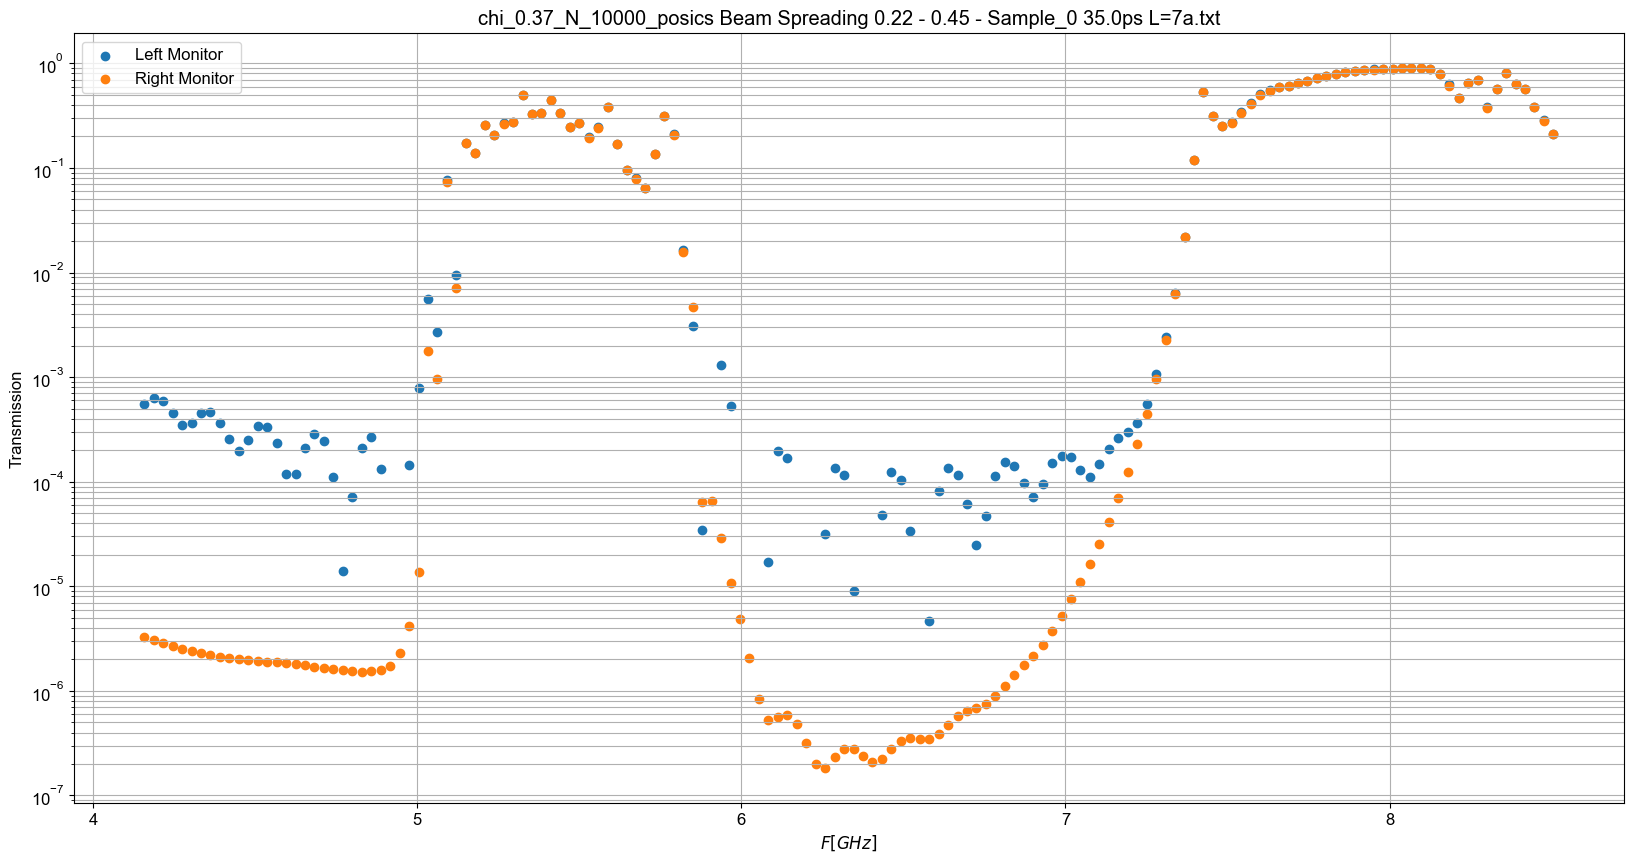

(742, 1, 150)
Configured successfully.


17:44:38 W. Europe Daylight Time Billed flex credit cost: 0.408.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

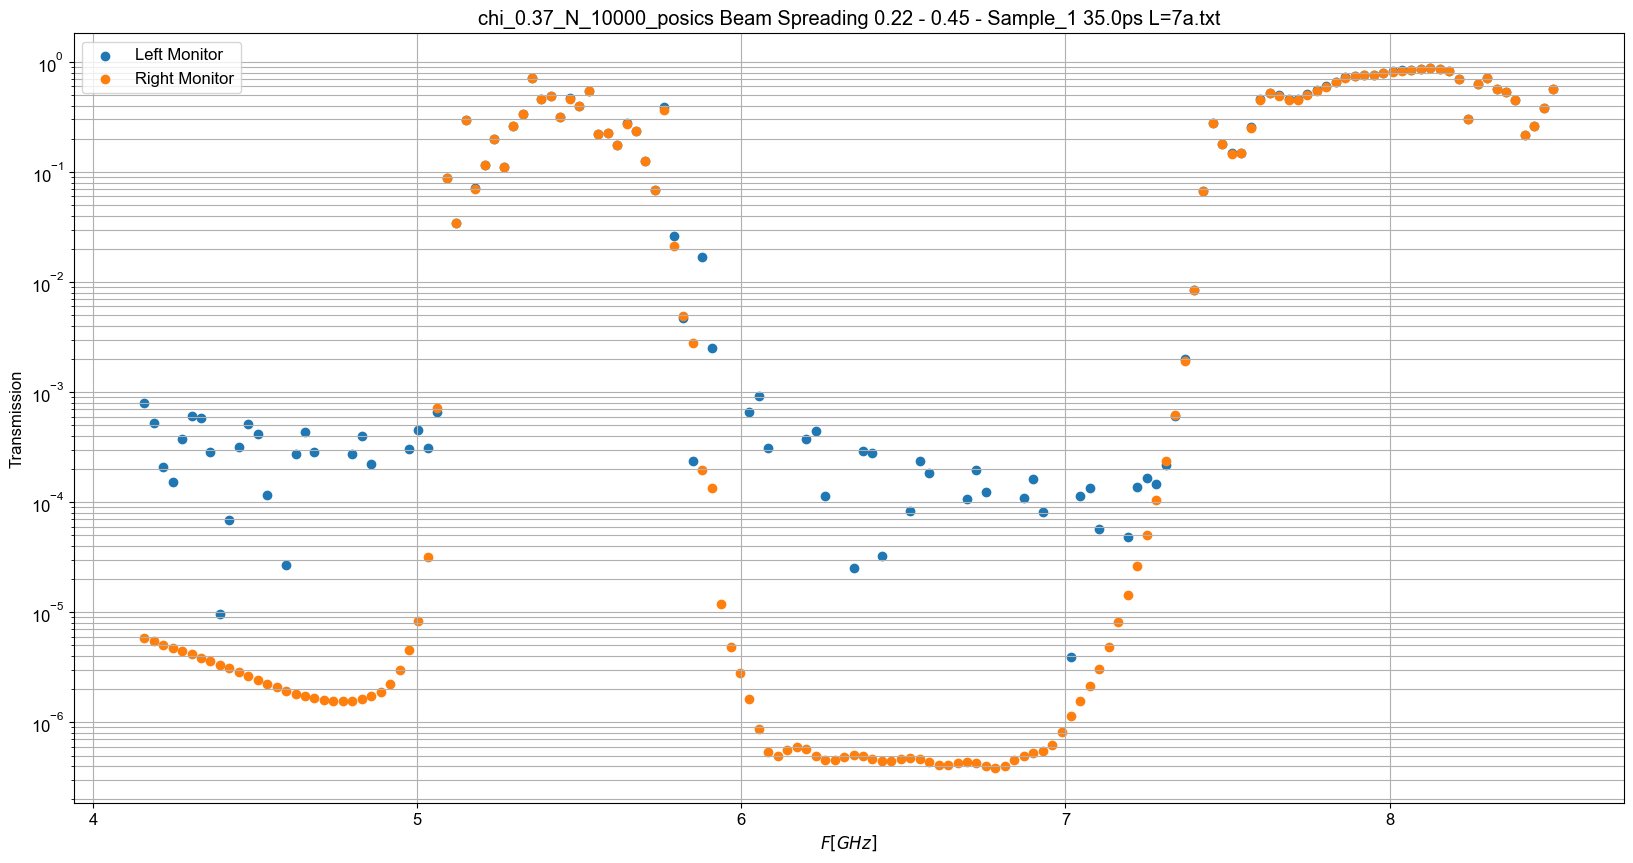

(742, 1, 150)


In [4]:
a=1
# data_field_intensities = np.zeros(shape=(2,1456,150))
data_field_intensities = np.zeros(shape=(2,742,150))
data_field_intensities_ref = np.zeros(shape=(2,742,150))
#Convergence
for path_direction in [
                 
                  # rf"H:\phd stuff\tidy3d\data\02_18_2025 2D Beam Spreading Broad Bandwidth Freq Domain Experimental setup\chi_0.37_N_10000_posics\chi_0.37_N_10000_posics_L=3.9 nu=0.05 - 0.35"
                  # rf"H:\phd stuff\tidy3d\data\02_18_2025 2D Beam Spreading Broad Bandwidth Freq Domain Experimental setup\chi_0.37_N_10000_posics\chi_0.37_N_10000_posics_L=3.9 nu=0.324 - 0.88183333"
                  # rf"H:\phd stuff\tidy3d\data\02_24_2025 2D Beam Spreading Antennas\chi_0.33_N_10000_posics\chi_0.33_N_10000_posics_L=4.4 nu=0.324 - 0.88183333"
                  # rf"H:\phd stuff\tidy3d\data\02_24_2025 2D Beam Spreading Antennas\chi_0.37_N_10000_posics\chi_0.37_N_10000_posics_L=4.4 nu=0.324 - 0.88183333"
                  # rf"H:\phd stuff\tidy3d\data\02_24_2025 2D Beam Spreading Antennas Waist 2.3\chi_0.37_N_10000_posics\chi_0.37_N_10000_posics_L=4.4 nu=0.324 - 0.88183333"
                  # rf"H:\phd stuff\tidy3d\data\20250505 2D Beam Spreading Antennas Waist 2.3\chi_0.37_N_10000_posics\chi_0.37_N_10000_posics_L=4.4 nu=0.28 - 0.44999999999999996"
                  rf"H:\phd stuff\tidy3d\data\20250505 2D Beam Spreading Antennas Waist 2.3\chi_0.37_N_10000_posics\chi_0.37_N_10000_posics_L=4.4 nu=0.22 - 0.44999999999999996"
                       ]:

      folder_path = f"{path_direction}"


      
      for i,filename in enumerate(natsorted(os.listdir(folder_path))):
            
            if not Path(filename).suffix==".txt":
                  continue

            
            if os.path.isfile(os.path.join(folder_path, filename)):
                file=os.path.join(folder_path, filename)
                structure_1 = AM.loadFromFile(key = tidy3dAPI, file_path=file)
                sim_data, sim_data0 = structure_1.sim_data, structure_1.sim_data0
                transmission0 = sim_data0['flux1'].flux
                transmission = sim_data['flux1'].flux
                transmission0_2 = sim_data0['flux2'].flux
                transmission_2 = sim_data['flux2'].flux
                transmission_normalized_1 = transmission / transmission0
                transmission_normalized_2 = transmission_2 / transmission0_2
                monitor_lambdas = C_mm/((td.C_0/np.array(np.array(sim_data.simulation.monitors)[0].freqs)) * 15.873)*1e-9
                plt.figure(figsize=(20, 10))
                plt.scatter(monitor_lambdas,transmission_normalized_2, label=f"Left Monitor")
                plt.scatter(monitor_lambdas,transmission_normalized_1, label=f"Right Monitor")
                plt.xlabel(rf'$F[GHz]$')
                plt.ylabel('Transmission')
                plt.legend()
                plt.grid(True,which="both")
                plt.yscale("log")
                plt.title(f"{filename}")
                plt.show()
                
                intensity =(sim_data.get_intensity("freq_monitorFieldOut").squeeze())
                intensity_ref =(sim_data0.get_intensity("freq_monitorFieldOut").squeeze())
                indices_x = np.where(np.bool_(intensity["x"]>=-55/2) & np.bool_(intensity["x"]<=55/2))[0]
                indices_y = np.array([np.where(np.bool_(intensity["y"]<=(-4.2)))[0][-1]])
                print( np.shape(intensity.values[np.ix_(indices_x,indices_y,np.arange((intensity.values).shape[2]))]))
                data_field_intensities[i] = intensity.values[np.ix_(indices_x,indices_y,np.arange((intensity.values).shape[2]))].squeeze()
                data_field_intensities_ref[i] = intensity_ref.values[np.ix_(indices_x,indices_y,np.arange((intensity_ref.values).shape[2]))].squeeze()


            #     create_movie(monitor_lambdas=monitor_lambdas,log=False,normalize=True, file_path=file, sample=i)
            
 
              
      
    
        


     

               



In [5]:
colors = [
          (1, 1, 1),  # White
          (0, 0, 1),  # Blue
          (1, 1, 0),  # Yellow
          (0, 1, 0),  # Green
          (1, 0, 0), #Red
          (0, 0, 0), # Black
          ]  

# Create a custom colormap
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

In [17]:
data_exit = np.copy(data_field_intensities_ref) #(sample, x_points, freqs)
value = np.mean(data_exit,axis=0)
value[value/np.max(value) <= 1e-6] = 0
value_normalized = value/np.max(value, axis=0)
value_normalized[np.isnan(value_normalized)] = 0

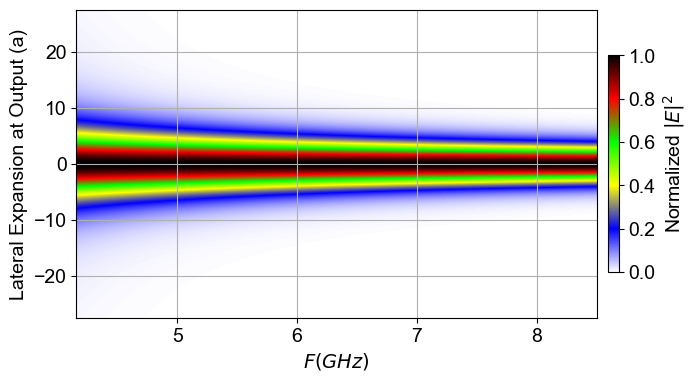

In [19]:
f = monitor_lambdas
plt.rcParams.update({'font.size': 14})  
fig, ax = plt.subplots(figsize=(7,4))
im=plt.imshow(value_normalized, vmin = np.min(value_normalized), vmax = np.max(value_normalized), 
                 extent =[np.min(f),np.max(f), -55/2,55/2], 
                    aspect='auto', interpolation="gaussian", cmap=cmap) 
# Add colorbar for reference
cbar = fig.colorbar(im, ax=ax, label=rf"$a/ \xi$",orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label(rf"Normalized $|E|^2$"
)
plt.xlabel(rf"$F(GHz)$")
plt.ylabel(rf"Lateral Expansion at Output (a)")
# plt.title(rf"L=7a $\chi=0.37$")
plt.grid(True,which="both")
plt.show()

In [8]:
def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w
def calculate_sigma(intensity_array, x1):
    x1 = np.asarray(x1)
    values = intensity_array

    # Reshape x1 to broadcast over columns (axis=1)
    x1 = x1[:, np.newaxis]  

    norm = scipy.integrate.trapezoid(values, x=x1[:, 0], axis=0)
    mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
    mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
    sigma = np.sqrt(mean_sq - mean**2)
    return sigma

def calculate_IPR(intensity_array,x1):
    values = intensity_array
    integral_1 = scipy.integrate.simpson(values**2, x=x1, axis=0)
    integral_2 = scipy.integrate.simpson(values, x=x1,axis=0)**2

    return integral_2/integral_1


data_exit = np.copy(data_field_intensities)
x_values = intensity["x"][np.where(np.bool_(intensity["x"]>=-55/2) & np.bool_(intensity["x"]<=55/2))[0]].values




In [9]:
average_xis_exit=calculate_IPR(value_normalized,x_values)
# average_xis_exit=calculate_sigma(value_normalized,x_values)
average_xis_exit[np.isnan(average_xis_exit)] = 0
average_xis_exit[np.isinf(average_xis_exit)] = 0

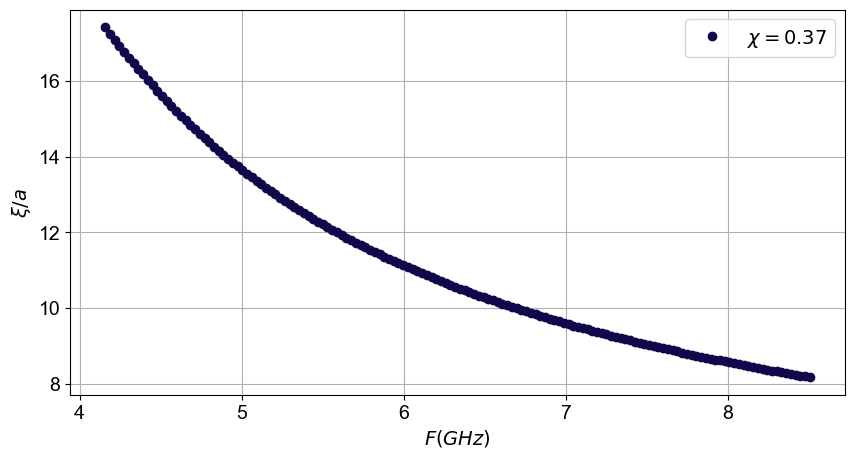

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(f,average_xis_exit, "o",label=rf"$\chi=0.37$",color="#0f084b")
plt.legend()
plt.xlabel(rf"$F(GHz)$")
plt.ylabel(rf"$\xi/a$")
# plt.ylim(0,10)
plt.grid(True,which="both")
plt.show()